Pandas started out in the financial world, so naturally it has strong timeseries support.

The first half of this post will look at pandas' capabilities for manipulating time series data.
The second half will discuss modelling time series data with statsmodels.

In [50]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')

In [51]:
gs = web.DataReader("GS", data_source='yahoo', start='2006-01-01',
                    end='2010-01-01')
gs.head().round(2)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,126.70,129.44,124.23,128.87,6188700,114.66
2006-01-04,127.35,128.91,126.38,127.09,4861600,113.08
2006-01-05,126.00,127.32,125.61,127.04,3717400,113.03
2006-01-06,127.29,129.25,127.29,128.84,4319600,114.63
2006-01-09,128.50,130.62,128.00,130.39,4723500,116.01


In [52]:
gs.head().round(2)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,126.70,129.44,124.23,128.87,6188700,114.66
2006-01-04,127.35,128.91,126.38,127.09,4861600,113.08
2006-01-05,126.00,127.32,125.61,127.04,3717400,113.03
2006-01-06,127.29,129.25,127.29,128.84,4319600,114.63
2006-01-09,128.50,130.62,128.00,130.39,4723500,116.01


We'll call any `DataFrame` or `Series` with a `DatetimeIndex` a timeseries.
There isn't a special data-container just for timeseries.
That said, `DataFrames` and `Series` with a `DatetiemIndex` do gain some special behaviors and additional methods.

## Special Slicing

Looking at the elements of `gs.index`, we see that `DatetimeIndex`es are made up of `pandas.Timestamp`s:

In [53]:
gs.index[0]

Timestamp('2006-01-03 00:00:00')

A `Timestamp` is mostly compatible with the `datetime.datetime` class, but much amenable to storage in arrays.

Working with `Timestamp`s can be a be awkward, so Series and DataFrames with `DatetimeIndexes` have some special slicing rules.
The first special case is *partial-string indexing*. Say we wanted to select all the days in 2006. Even with `Timestamp`'s convienient constructors, it's a pain.

In [54]:
gs.loc[pd.Timestamp('2006-01-01'):pd.Timestamp('2006-12-31')].head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,6188700,114.660688
2006-01-04,127.349998,128.910004,126.379997,127.089996,4861600,113.076954
2006-01-05,126.000000,127.320000,125.610001,127.040001,3717400,113.032471
2006-01-06,127.290001,129.250000,127.290001,128.839996,4319600,114.633997
2006-01-09,128.500000,130.619995,128.000000,130.389999,4723500,116.013096


Thanks to partial-string indexing, it's as simple as

In [55]:
gs.loc['2006'].head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,6188700,114.660688
2006-01-04,127.349998,128.910004,126.379997,127.089996,4861600,113.076954
2006-01-05,126.000000,127.320000,125.610001,127.040001,3717400,113.032471
2006-01-06,127.290001,129.250000,127.290001,128.839996,4319600,114.633997
2006-01-09,128.500000,130.619995,128.000000,130.389999,4723500,116.013096


Since label slicing is inclusive, this slice selects any observation where the year is 2006.

The second "conveninece" is `__getitem__` (squre-braket slicing) fallback indexing. I'm only going to mention it here, with the caveat that you should never use it.
DataFrame `__getitem__` typically looks in the column: `gs['2006']` would search `gs.columns` for `'2006'`, not find it, and raise a `KeyError`. But DataFrames with a `DatetimeIndex` catch that `KeyError` and try to slice the index.
If it succeeds in slicing the index, the result like `gs.loc['2006']` is returned.
If it fails, the `KeyError` is reraised.
This is confusing because in every other case `DataFrame.__getitem__` works on columns, and it's fragile becuase if you happened to have a column `'2006'` you *would* get just that column, and no fallback indexing would occur. Just use `gs.loc['2006']` when slicing DataFrame indexes.

## Special Methods

### Resampling

Resampling is similar to a `groupby`: you split the time series into groups (5-day buckets below), apply a function to each group (`mean`), and combine the result (one row per group).

In [56]:
gs.resample("5d").mean().head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,126.834999,128.730002,125.877501,127.959997,4771825,113.851027
2006-01-08,130.349998,132.645000,130.205002,131.660000,4664300,117.143065
2006-01-13,131.510002,133.395005,131.244995,132.924995,3258250,118.268581
2006-01-18,132.210002,133.853333,131.656667,132.543335,4997766,118.001965
2006-01-23,133.771997,136.083997,133.310001,135.153998,3968500,120.476883


In [57]:
gs.resample("W").agg(['mean', 'sum']).head()

Open                    High                     Low  \
                  mean         sum        mean         sum        mean   
Date                                                                     
2006-01-08  126.834999  507.339996  128.730002  514.920006  125.877501   
2006-01-15  130.684000  653.419998  132.848001  664.240006  130.544000   
2006-01-22  131.907501  527.630005  133.672501  534.690003  131.389999   
2006-01-29  133.771997  668.859986  136.083997  680.419983  133.310001   
2006-02-05  140.900000  704.500000  142.467999  712.339996  139.937998   

                             Close               Volume             Adj Close  \
                   sum        mean         sum     mean       sum        mean   
Date                                                                            
2006-01-08  503.510002  127.959997  511.839988  4771825  19087300  113.851027   
2006-01-15  652.720001  131.979999  659.899994  4310420  21552100  117.427781   
2006-01-22  525.559998  132.555000  530.220000  4653725  18614900  117.994103   
2006-01-29  666.550003  135.153998  675.769989  3968500  19842500  120.476883   
2006-02-05  699.689988  141.618002  708.090011  3920120  19600600  126.238926   

                        
                   sum  
Date                    
2006-01-08  455.404110  
2006-01-15  587.138903  
2006-01-22  471.976414  
2006-01-29  602.384416  
2006-02-05  631.194630

You can upsample to convert to a higher frequency.
The new points are filled with NaNs.

In [58]:
gs.resample("6H").mean().head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-01-03 00:00:00,126.699997,129.440002,124.230003,128.869995,6188700.0,114.660688
2006-01-03 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04 00:00:00,127.349998,128.910004,126.379997,127.089996,4861600.0,113.076954


### Rolling / Expanding / EW

These methods aren't unique to DatetimeIndexes, but they often make sense with timeseries, so I'll show them here.

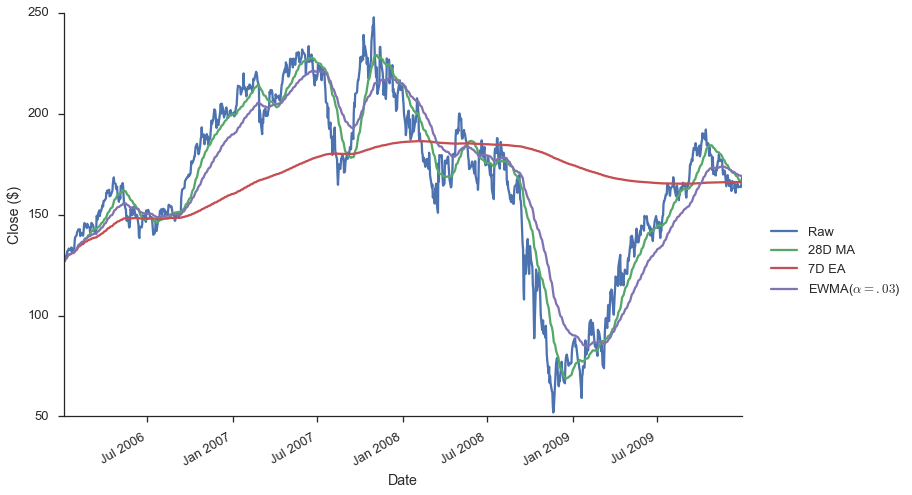

In [60]:
gs.Close.plot(label='Raw')
gs.Close.rolling(28).mean().plot(label='28D MA')
gs.Close.expanding().mean().plot(label='Expanding Average')
gs.Close.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)')

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()
plt.savefig('../content/images/ts-reew.svg')

Each of `.rolling`, `.expanding`, and `.ewm` return a deferred object, similar to a GroupBy.

In [61]:
roll = gs.Close.rolling(30, center=True)
roll

Rolling [window=30,center=True,axis=0]

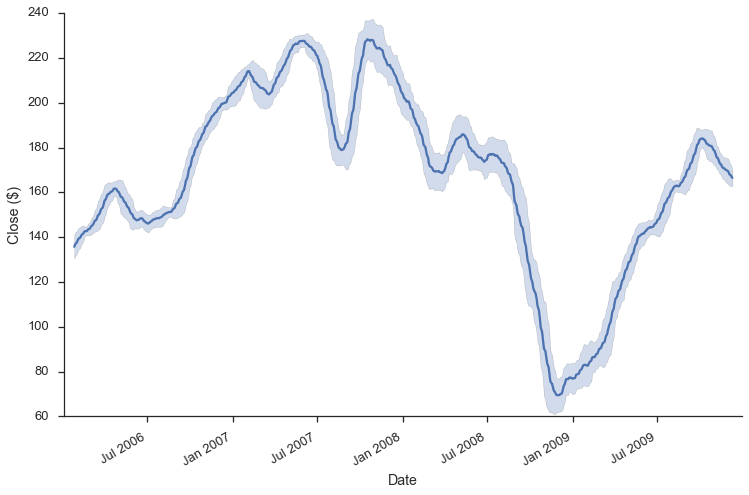

In [70]:
m = roll.agg(['mean', 'std'])
ax = m['mean'].plot()
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                alpha=.25)
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()
plt.savefig('../content/images/ts-roll.svg')

## Grab Bag

### Offsets

These are similar to `dateutil.relativedelta`, but works with arrays.

In [71]:
gs.index + pd.DateOffset(months=3, days=-2)

DatetimeIndex(['2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-07', '2006-04-08', '2006-04-09', '2006-04-10',
               '2006-04-11', '2006-04-15',
               ...
               '2010-03-15', '2010-03-16', '2010-03-19', '2010-03-20',
               '2010-03-21', '2010-03-22', '2010-03-26', '2010-03-27',
               '2010-03-28', '2010-03-29'],
              dtype='datetime64[ns]', name='Date', length=1007, freq=None)

### Holiday Calendars

There are a whole bunch of special calendars, useful for traders probabaly.

In [72]:
from pandas.tseries.holiday import USColumbusDay

In [73]:
USColumbusDay.dates('2015-01-01', '2020-01-01')

DatetimeIndex(['2015-10-12', '2016-10-10', '2017-10-09', '2018-10-08',
               '2019-10-14'],
              dtype='datetime64[ns]', freq='WOM-2MON')

### Timezones

Pandas works with `pytz` for nice timezone-aware datetimes.
The typical workflow is

1. localize timezone-naive timestamps to some timezone
2. convert to desired timezone

If you already have timezone-aware Timestamps, there's no need for step one. 

In [74]:
# tz naiive -> tz aware..... to desired UTC
gs.tz_localize('US/Eastern').tz_convert('UTC').head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-01-03 05:00:00+00:00,126.699997,129.440002,124.230003,128.869995,6188700,114.660688
2006-01-04 05:00:00+00:00,127.349998,128.910004,126.379997,127.089996,4861600,113.076954
2006-01-05 05:00:00+00:00,126.000000,127.320000,125.610001,127.040001,3717400,113.032471
2006-01-06 05:00:00+00:00,127.290001,129.250000,127.290001,128.839996,4319600,114.633997
2006-01-09 05:00:00+00:00,128.500000,130.619995,128.000000,130.389999,4723500,116.013096


# Modeling Time Series

The rest of this post will focus on time series in the econometric sense.
My indented reader for this section isn't all that clear, so I apologize upfront for any sudden shifts in complexity.
I'm roughly targeting material that could be presented in a first or second semester applied statisctics course.
What follows certainly isn't a replacement for that.
Any formality will be restricted to footnotes for the curious.
I've put a whole bunch of resources at the end for people earger to learn more.

We'll focus on modelling Average Monthly Flights. Let's download the data.
If you've been following along in the series, you've seen most of this code before, so feel free to skip.

In [67]:
import os
import io
import glob
import zipfile

import requests
import statsmodels.api as sm


def download_one(date):
    '''
    Download a single month's flights
    '''
    month = date.month
    year = date.year
    month_name = date.strftime('%B')
    headers = {
        'Pragma': 'no-cache',
        'Origin': 'http://www.transtats.bts.gov',
        'Accept-Encoding': 'gzip, deflate',
        'Accept-Language': 'en-US,en;q=0.8',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.87 Safari/537.36',
        'Content-Type': 'application/x-www-form-urlencoded',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Cache-Control': 'no-cache',
        'Referer': 'http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time',
        'Connection': 'keep-alive',
        'DNT': '1',
    }
    os.makedirs('timeseries', exist_ok=True)
    data = 'UserTableName=On_Time_Performance&DBShortName=On_Time&RawDataTable=T_ONTIME&sqlstr=+SELECT+FL_DATE%2CUNIQUE_CARRIER%2CCARRIER%2CTAIL_NUM%2CFL_NUM%2CORIGIN%2CDEST%2CCRS_DEP_TIME%2CDEP_TIME%2CTAXI_OUT%2CWHEELS_OFF%2CWHEELS_ON%2CTAXI_IN%2CCRS_ARR_TIME%2CARR_TIME%2CDISTANCE%2CCARRIER_DELAY%2CWEATHER_DELAY%2CNAS_DELAY%2CSECURITY_DELAY%2CLATE_AIRCRAFT_DELAY+FROM++T_ONTIME+WHERE+%28+DEST_STATE_NM%3D%27Illinois%27+OR+ORIGIN_STATE_NM+%3D%27Illinois%27+%29++AND+Month+%3D{month}+AND+YEAR%3D{year}&varlist=FL_DATE%2CUNIQUE_CARRIER%2CCARRIER%2CTAIL_NUM%2CFL_NUM%2CORIGIN%2CDEST%2CCRS_DEP_TIME%2CDEP_TIME%2CTAXI_OUT%2CWHEELS_OFF%2CWHEELS_ON%2CTAXI_IN%2CCRS_ARR_TIME%2CARR_TIME%2CDISTANCE%2CCARRIER_DELAY%2CWEATHER_DELAY%2CNAS_DELAY%2CSECURITY_DELAY%2CLATE_AIRCRAFT_DELAY&grouplist=&suml=&sumRegion=&filter1=title%3D&filter2=title%3D&geo=Illinois&time={month_name}&timename=Month&GEOGRAPHY=Illinois&XYEAR={year}&FREQUENCY={month}&VarDesc=Year&VarType=Num&VarDesc=Quarter&VarType=Num&VarDesc=Month&VarType=Num&VarDesc=DayofMonth&VarType=Num&VarDesc=DayOfWeek&VarType=Num&VarName=FL_DATE&VarDesc=FlightDate&VarType=Char&VarName=UNIQUE_CARRIER&VarDesc=UniqueCarrier&VarType=Char&VarDesc=AirlineID&VarType=Num&VarName=CARRIER&VarDesc=Carrier&VarType=Char&VarName=TAIL_NUM&VarDesc=TailNum&VarType=Char&VarName=FL_NUM&VarDesc=FlightNum&VarType=Char&VarDesc=OriginAirportID&VarType=Num&VarDesc=OriginAirportSeqID&VarType=Num&VarDesc=OriginCityMarketID&VarType=Num&VarName=ORIGIN&VarDesc=Origin&VarType=Char&VarDesc=OriginCityName&VarType=Char&VarDesc=OriginState&VarType=Char&VarDesc=OriginStateFips&VarType=Char&VarDesc=OriginStateName&VarType=Char&VarDesc=OriginWac&VarType=Num&VarDesc=DestAirportID&VarType=Num&VarDesc=DestAirportSeqID&VarType=Num&VarDesc=DestCityMarketID&VarType=Num&VarName=DEST&VarDesc=Dest&VarType=Char&VarDesc=DestCityName&VarType=Char&VarDesc=DestState&VarType=Char&VarDesc=DestStateFips&VarType=Char&VarDesc=DestStateName&VarType=Char&VarDesc=DestWac&VarType=Num&VarName=CRS_DEP_TIME&VarDesc=CRSDepTime&VarType=Char&VarName=DEP_TIME&VarDesc=DepTime&VarType=Char&VarDesc=DepDelay&VarType=Num&VarDesc=DepDelayMinutes&VarType=Num&VarDesc=DepDel15&VarType=Num&VarDesc=DepartureDelayGroups&VarType=Num&VarDesc=DepTimeBlk&VarType=Char&VarName=TAXI_OUT&VarDesc=TaxiOut&VarType=Num&VarName=WHEELS_OFF&VarDesc=WheelsOff&VarType=Char&VarName=WHEELS_ON&VarDesc=WheelsOn&VarType=Char&VarName=TAXI_IN&VarDesc=TaxiIn&VarType=Num&VarName=CRS_ARR_TIME&VarDesc=CRSArrTime&VarType=Char&VarName=ARR_TIME&VarDesc=ArrTime&VarType=Char&VarDesc=ArrDelay&VarType=Num&VarDesc=ArrDelayMinutes&VarType=Num&VarDesc=ArrDel15&VarType=Num&VarDesc=ArrivalDelayGroups&VarType=Num&VarDesc=ArrTimeBlk&VarType=Char&VarDesc=Cancelled&VarType=Num&VarDesc=CancellationCode&VarType=Char&VarDesc=Diverted&VarType=Num&VarDesc=CRSElapsedTime&VarType=Num&VarDesc=ActualElapsedTime&VarType=Num&VarDesc=AirTime&VarType=Num&VarDesc=Flights&VarType=Num&VarName=DISTANCE&VarDesc=Distance&VarType=Num&VarDesc=DistanceGroup&VarType=Num&VarName=CARRIER_DELAY&VarDesc=CarrierDelay&VarType=Num&VarName=WEATHER_DELAY&VarDesc=WeatherDelay&VarType=Num&VarName=NAS_DELAY&VarDesc=NASDelay&VarType=Num&VarName=SECURITY_DELAY&VarDesc=SecurityDelay&VarType=Num&VarName=LATE_AIRCRAFT_DELAY&VarDesc=LateAircraftDelay&VarType=Num&VarDesc=FirstDepTime&VarType=Char&VarDesc=TotalAddGTime&VarType=Num&VarDesc=LongestAddGTime&VarType=Num&VarDesc=DivAirportLandings&VarType=Num&VarDesc=DivReachedDest&VarType=Num&VarDesc=DivActualElapsedTime&VarType=Num&VarDesc=DivArrDelay&VarType=Num&VarDesc=DivDistance&VarType=Num&VarDesc=Div1Airport&VarType=Char&VarDesc=Div1AirportID&VarType=Num&VarDesc=Div1AirportSeqID&VarType=Num&VarDesc=Div1WheelsOn&VarType=Char&VarDesc=Div1TotalGTime&VarType=Num&VarDesc=Div1LongestGTime&VarType=Num&VarDesc=Div1WheelsOff&VarType=Char&VarDesc=Div1TailNum&VarType=Char&VarDesc=Div2Airport&VarType=Char&VarDesc=Div2AirportID&VarType=Num&VarDesc=Div2AirportSeqID&VarType=Num&VarDesc=Div2WheelsOn&VarType=Char&VarDesc=Div2TotalGTime&VarType=Num&VarDesc=Div2LongestGTime&VarType=Num&VarDesc=Div2WheelsOff&VarType=Char&VarDesc=Div2TailNum&VarType=Char&VarDesc=Div3Airport&VarType=Char&VarDesc=Div3AirportID&VarType=Num&VarDesc=Div3AirportSeqID&VarType=Num&VarDesc=Div3WheelsOn&VarType=Char&VarDesc=Div3TotalGTime&VarType=Num&VarDesc=Div3LongestGTime&VarType=Num&VarDesc=Div3WheelsOff&VarType=Char&VarDesc=Div3TailNum&VarType=Char&VarDesc=Div4Airport&VarType=Char&VarDesc=Div4AirportID&VarType=Num&VarDesc=Div4AirportSeqID&VarType=Num&VarDesc=Div4WheelsOn&VarType=Char&VarDesc=Div4TotalGTime&VarType=Num&VarDesc=Div4LongestGTime&VarType=Num&VarDesc=Div4WheelsOff&VarType=Char&VarDesc=Div4TailNum&VarType=Char&VarDesc=Div5Airport&VarType=Char&VarDesc=Div5AirportID&VarType=Num&VarDesc=Div5AirportSeqID&VarType=Num&VarDesc=Div5WheelsOn&VarType=Char&VarDesc=Div5TotalGTime&VarType=Num&VarDesc=Div5LongestGTime&VarType=Num&VarDesc=Div5WheelsOff&VarType=Char&VarDesc=Div5TailNum&VarType=Char'

    r = requests.post('http://www.transtats.bts.gov/DownLoad_Table.asp?Table_ID=236&Has_Group=3&Is_Zipped=0',
                      headers=headers, data=data.format(year=year, month=month, month_name=month_name),
                      stream=True)
    fp = os.path.join('timeseries', '{}-{}.zip'.format(year, month))

    with open(fp, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)
    return fp
    
def download_many(start, end):
    months = pd.date_range(start, end=end, freq='M')    
    # We could easily parallelize this loop.
    for i, month in enumerate(months):
        download_one(month)
    
def unzip_one(fp):
    zf = zipfile.ZipFile(fp)
    csv = zf.extract(zf.filelist[0])
    return csv

def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.
    
    2014-01-01,1149.0 -> 2014-01-01T11:49:00
    '''
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return  pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
        return datetime_part
    df[columns] = df[columns].apply(converter)
    return df


def read_one(fp):
    df = (pd.read_csv(fp, encoding='latin1')
            .rename(columns=str.lower)
            .drop('unnamed: 21', axis=1)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time',
                                     'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date'])))
    return df

In [68]:
download_many('2000-01-01', '2016-01-01')

zips = glob.glob(os.path.join('timeseries', '*.zip'))
csvs = [unzip_one(fp) for fp in zips]
dfs = [read_one(fp) for fp in csvs]
df = pd.concat(dfs, ignore_index=True)

ReadTimeout: HTTPConnectionPool(host='www.transtats.bts.gov', port=80): Read timed out. (read timeout=None)

In [10]:
with pd.option_context('display.max_rows', 100):
    print(df.dtypes)

fl_date                datetime64[ns]
unique_carrier               category
carrier                      category
tail_num                     category
fl_num                          int64
origin                       category
dest                         category
crs_dep_time           datetime64[ns]
dep_time               datetime64[ns]
taxi_out                      float64
wheels_off                    float64
wheels_on                     float64
taxi_in                       float64
crs_arr_time           datetime64[ns]
arr_time               datetime64[ns]
distance                      float64
carrier_delay                 float64
weather_delay                 float64
nas_delay                     float64
security_delay                float64
late_aircraft_delay           float64
dtype: object


In [8]:
cat_cols = ['unique_carrier', 'carrier', 'tail_num', 'origin', 'dest']

df[cat_cols] = df[cat_cols].apply(pd.Categorical)

df.to_hdf('ts.hdf5', 'ts', format='table')

In [75]:
df = pd.read_hdf('ts.hdf5', 'ts')

We can calculate the historical values with a resample.

In [76]:
daily = df.fl_date.value_counts().sort_index()
y = daily.resample('MS').mean()
y.head()

2000-01-01    1882.387097
2000-02-01    1926.896552
2000-03-01    1951.000000
2000-04-01    1944.400000
2000-05-01    1957.967742
Freq: MS, Name: fl_date, dtype: float64

Note that I use the `"MS"` frequency code there.
Pandas defaults to end of month (or end of year).
Append an `'S'` to get the start.

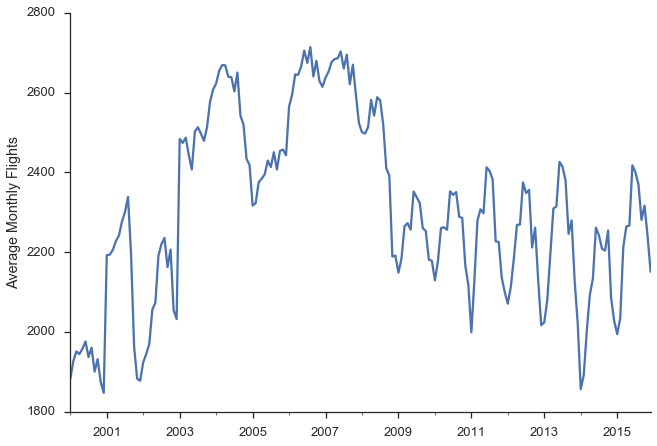

In [77]:
ax = y.plot()
ax.set(ylabel='Average Monthly Flights')
sns.despine()
plt.savefig('../content/images/ts-y.svg')

In [78]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

Think back to a typical regression problem, ignoring anything to do wtih time series for now.
The usual task is to predict some value $y$ using some a linear combination of features in $X$.

$$y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$

When working with time series, some of the most important (and sometimes *only*) features are the previous, or *lagged*, values of $y$.

We'll start by doing just that: running a regression of `y` on lagged values of itself.
We'll see that this regression suffers from a few problems: multicolinearity, autocorrelation, non-stationarity, and seasonality.
Once we touch on each of those problems, we'll use a second model, seasonal ARIMA, which handles those problems for us.

First, let's create a dataframe with our lagged values of `y` using the `.shift` method, which shifts the index `i` periods, so it lines up with that observation.

In [79]:
X = (pd.concat([y.shift(i) for i in range(6)], axis=1,
               keys=['y'] + ['L%s' % i for i in range(1, 6)])
       .dropna())
X.head()

,y,L1,L2,L3,L4,L5
2000-06-01,1976.133333,1957.967742,1944.400000,1951.000000,1926.896552,1882.387097
2000-07-01,1937.032258,1976.133333,1957.967742,1944.400000,1951.000000,1926.896552
2000-08-01,1960.354839,1937.032258,1976.133333,1957.967742,1944.400000,1951.000000
2000-09-01,1900.533333,1960.354839,1937.032258,1976.133333,1957.967742,1944.400000
2000-10-01,1931.677419,1900.533333,1960.354839,1937.032258,1976.133333,1957.967742


We can fit the lagged model using statsmodels (which uses [patsy](http://patsy.readthedocs.org) to translate the formula string to a design matrix).

In [80]:
mod_lagged = smf.ols('y ~ trend + L1 + L2 + L3 + L4 + L5',
                     data=X.assign(trend=np.arange(len(X))))
res_lagged = mod_lagged.fit()
res_lagged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     221.7
Date:                Sun, 15 May 2016   Prob (F-statistic):           2.40e-80
Time:                        07:01:31   Log-Likelihood:                -1076.6
No. Observations:                 187   AIC:                             2167.
Df Residuals:                     180   BIC:                             2190.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    208.2440     65.495      3.180      0.002      79.008     337.480
trend         -0.1123      0.106     -1.055      0.293      -0.322       0.098
L1             1.0489      0.075     14.052      0.000       0.902       1.196
L2            -0.0001      0.108     -0.001      0.999      -0.213       0.213
L3            -0.1450      0.108     -1.346      0.180      -0.358       0.068
L4            -0.0393      0.109     -0.361      0.719      -0.254       0.175
L5             0.0506      0.074      0.682      0.496      -0.096       0.197
==============================================================================
Omnibus:                       55.872   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.488
Skew:                           0.956   Prob(JB):                     9.39e-71
Kurtosis:                       9.142   Cond. No.                     5.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There are a few problems with this approach though.
Since our lagged values are highly correlated with each other, our regression suffers from multicollinearity.
That ruins our estimates of the slopes.

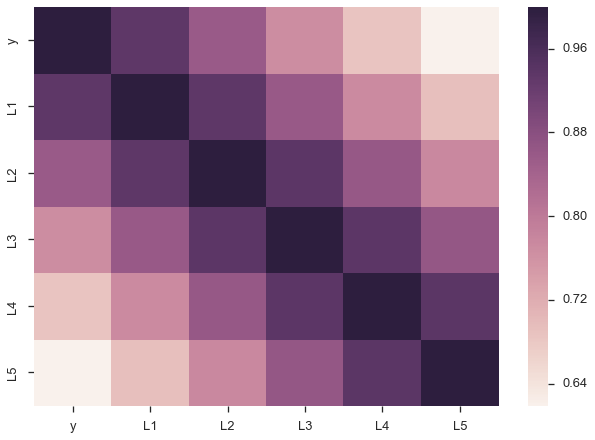

In [82]:
sns.heatmap(X.corr())
plt.savefig('../content/images/ts-corr.svg')

Seoncd, we'd intuitively expect the $\beta_i$s to gradually decline to zero.
The immediately preceding period should be most important ($\beta_1$ is the largest coefficient in absolute value), followed by $\beta_2$, and $\beta_3$...
Looking at the regression summary and the bar graph below, this isn't the case (the cause is related to multicolinearity).

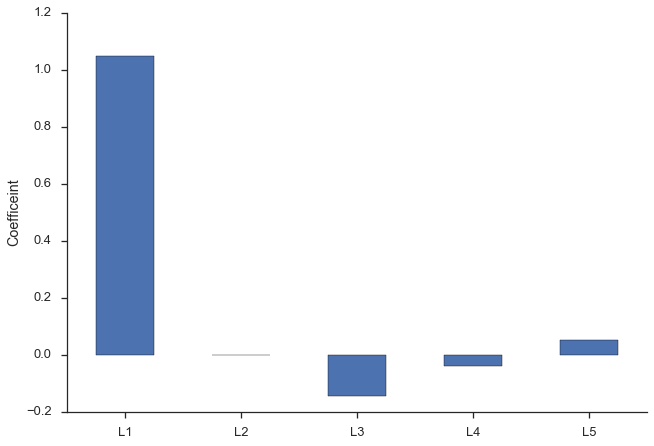

In [83]:
ax = res_lagged.params.drop(['Intercept', 'trend']).plot.bar(rot=0)
plt.ylabel('Coefficeint')
sns.despine()
plt.savefig('../content/images/ts-lagged-coef.svg')

Finally, our degrees of freedom drop since we lose two for each variable (one for estimating the coefficient, one for the lost observation as a result of the `shift`).
At least in (macro)econometrics, each observation is precious and we're loath to throw them away, though sometimes that's unavoidable.

### Autocorrelation

Another problem our lagged model suffered from is autocorrelation (also know as serial correlation).
Roughly speaking, autocorrelation is when there's a clear pattern in the residuals.
Let's fit a simple model of $y = \beta_0 + \beta_1 T + \epsilon$, where `T` is the time trend (`np.arange(len(y))`).

In [84]:
# `Results.resid` is a Series of residuals: y - ŷ
mod_trend = sm.OLS.from_formula(
    'y ~ trend', data=y.to_frame(name='y')
                       .assign(trend=np.arange(len(y))))
res_trend = mod_trend.fit()

Residuals (the observed minus the expected, or $\hat{e_t} = y_t - \hat{y_t}$) are supposed to be [white noise](https://en.wikipedia.org/wiki/White_noise).
That's [one of the assumptions](https://en.wikipedia.org/wiki/Gauss–Markov_theorem) many of the properties of linear regression are founded upon.
In this case there's a correlation between one residual and the next: if the residual at time $t$ was above expecation, then the residual at time $t + 1$ is *much* more likely to be above average as well ($e_t > 0 \implies E_t[e_{t+1}] > 0$).

We'll define a helper function to plot the residuals time series, and some diagnostics about them.

In [85]:
def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

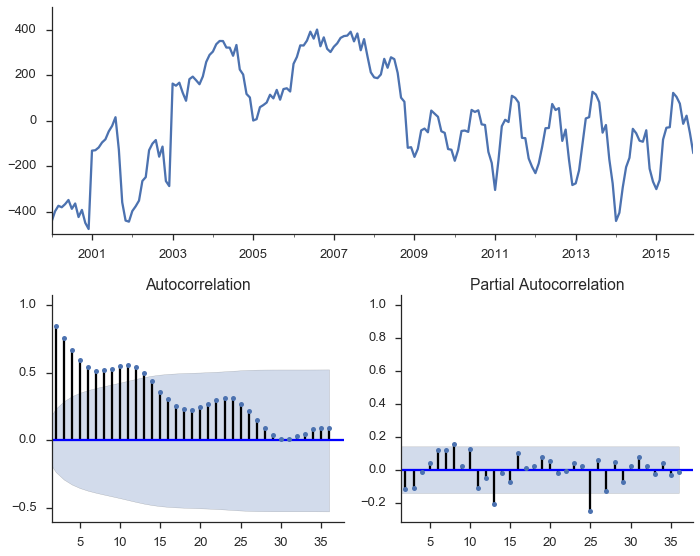

In [87]:
tsplot(res_trend.resid, lags=36)
plt.savefig('../content/images/ts-res-trend-tsplot.svg')

The top subplot shows the time series of our residuals $e_t$.
The bottom left is the [autocorrelation](https://www.otexts.org/fpp/2/2#autocorrelation) of the residuals.
It measures the correlation between a a value and it's lagged self, e.g. $corr(e_t, e_{t-1}), corr(e_t, e_{t-2}), \ldots$.
I won't really go into partial autocorrelation, but it's a similar concept.

Autocorelation is a problem in regular regressions like above, but we'll use it to our advantage when we setup an ARIMA model below.

## Stationarity

It's important that your dataset be stationary, otherwise you run the risk of finding [spurious correlations](http://www.tylervigen.com/spurious-correlations).
Granger and Newbold (1974) as well.
The typical way to handle non-stationarity is to difference the non-stationary variable until is is stationary.

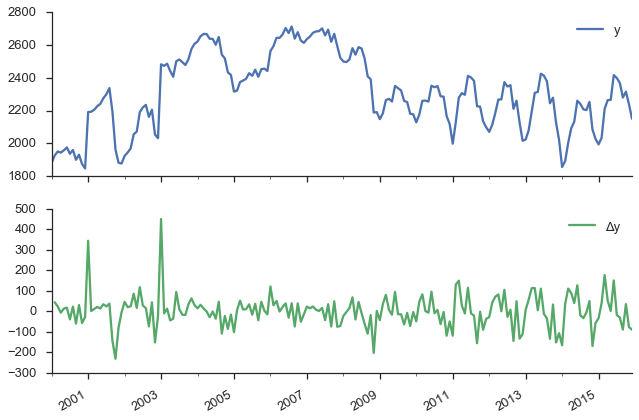

In [88]:
y.to_frame(name='y').assign(Δy=lambda x: x.y.diff()).plot(subplots=True)
sns.despine()
plt.savefig('../content/images/ts-y-deltay.svg')

Our original series actually doesn't look *that* bad.
But we have more rigorous methods for detetcing whether a series is non-stationary.
One example is the Augmented Dickey-Fuller test.
It's a statistical hypothesis test that says:

$H_0$ (null hypothesis): $y$ is non-stationary

$H_A$ (alternative hypothesis): $y$ is stationary


$$y_t^\prime = \phi y_{t-1} + \beta_1 y_{t-1}^\prime + \beta_2 y_{t-2}^\prime + \ldots + \beta_k y_{t-k}^\prime$$

This is implemented in statsmodels as `smt.adfuller`. The return type is a bit busy for me, so we'll wrap it in a `namedtuple`.

In [89]:
from collections import namedtuple

ADF = namedtuple("ADF", "adf pvalue usedlag nobs critical icbest")

In [90]:
ADF(*smt.adfuller(y))._asdict()

OrderedDict([('adf', -1.9904608794641487),
             ('pvalue', 0.29077127047555601),
             ('usedlag', 15),
             ('nobs', 176),
             ('critical',
              {'1%': -3.4680615871598537,
               '10%': -2.5756015922004134,
               '5%': -2.8781061899535128}),
             ('icbest', 1987.6605732826176)])

So we failed to reject the null hypothesis that the original series was non-stationary.
Let's difference it.

In [91]:
ADF(*smt.adfuller(y.diff().dropna()))._asdict()

OrderedDict([('adf', -3.5862361055645211),
             ('pvalue', 0.0060296818910968268),
             ('usedlag', 14),
             ('nobs', 176),
             ('critical',
              {'1%': -3.4680615871598537,
               '10%': -2.5756015922004134,
               '5%': -2.8781061899535128}),
             ('icbest', 1979.6445486427308)])

This looks better.
It's not statistically significant at the 5% level, but who cares what statisticins say anyway.

We'll fit another OLS model of $\Delta y = \beta_0 + \beta_1 L \Delta y_{t-1} + e_t$

In [92]:
data = (y.to_frame(name='y')
         .assign(Δy=lambda df: df.y.diff())
         .assign(LΔy=lambda df: df.Δy.shift()))
mod_stationary = smf.ols('Δy ~ LΔy', data=data.dropna())
res_stationary = mod_stationary.fit()

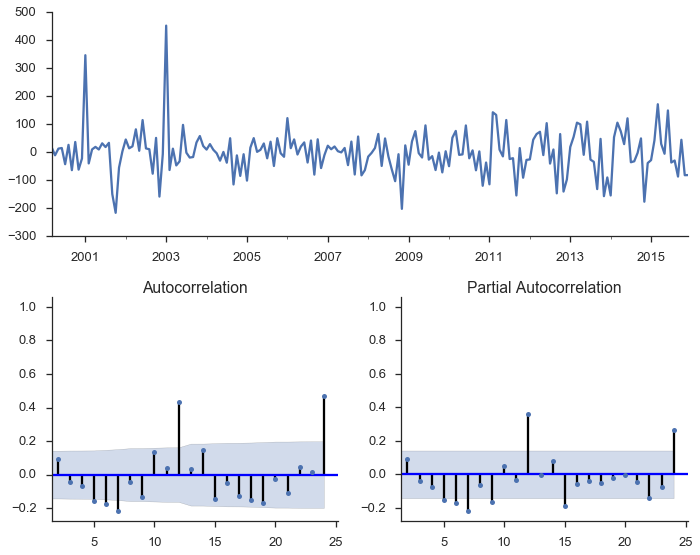

In [93]:
tsplot(res_stationary.resid, lags=24)
plt.savefig('../content/images/ts-stationary.svg')

So we've taken care of multicolinearity, autocorelation, and stationarity, but we still aren't done.

## Seasonality

Our last issue to deal with is seasonality: we have strong monthly seasonality.

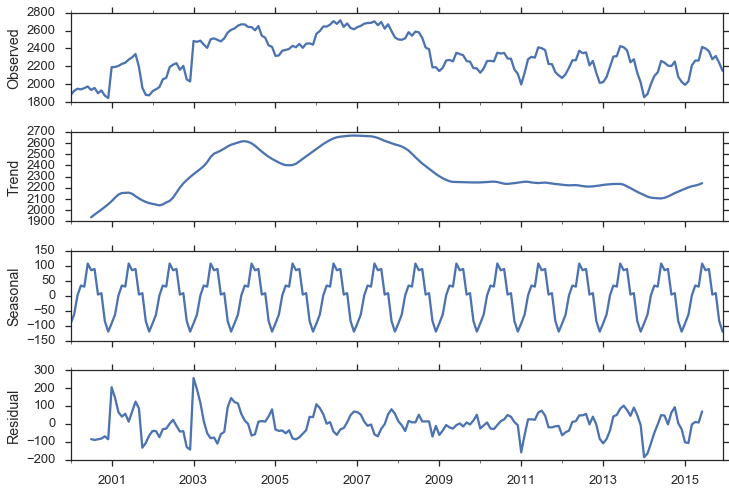

In [95]:
smt.seasonal_decompose(y).plot()
plt.savefig('../content/images/ts-decompose.svg')

There are a few ways to handle seasonality. We'll just rely on the `SARIMAX` method to do it for us. For now, recognize that it's a problem.

## ARIMA

So, we've sketched the problems with regular old regression: multicolinearity, autocorrelation, non-stationarity, and seasonality.
Our tool of choice, `smt.SARIMAX`, which stands for Seasonal ARIMA with eXogenous regressors, can handle all these.
We'll walk through the components in pieces.

ARIMA stands for AutoRegressive Integrated Moving Average, and it's a relatively simple way of modeling univariate time series.
It's made up of three components, and is typically written as $\mathrm{ARIMA}(p, d, q)$.

### [AutoRegressive](https://www.otexts.org/fpp/8/3)

The idea is to predict a variable by a linear combination of its lagged values (*auto*-regressive as in regressing a value on its past *self*).
An AR(p), where $p$ repgresents the number of past values used, is written as

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + e_t$$

$c$ is a constant and $e_t$ is white noise. Other than that this is quite similar to a linear regression model with multiple predictors, but the predictors happen to be lagged values of $y$ (though they are estimated differently).

### Integrated

Integrated is like the opposite of differencing, and is the part that deals with stationarity.
If you have to difference your dataset 1 time to get it stationary, then $d=1$.
We'll introduce one bit of notation for differencing: $\Delta y_t = y_t - y_{t-1}$ for $d=1$.

### [Moving Average](https://www.otexts.org/fpp/8/4)

MA models look somewhat similar to the AR component, but it's dealing with different values.

$$y_t = c + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \ldots + \theta_q e_{t-q}$$

$c$ again is a constant and $e_t$ again is white noise.
But now the coefficients are the *residuals* from previous predictions.

### Combining

Putting that together, we have an ARIMA(1, 1, 1) proces is written as

$$\Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_t e_{t-1} + e_t$$ 

Using *lag notation*, where $L y_t = y_{t-1}$, i.e. `y.shift()` in pandas, we can rewrite that as

$$(1 - \phi_1 L) (1 - L)y_t = c + (1 + \theta L)e_t$$

For our ARIMA(1, 1, 1) model. In general that becomes

$$(1 - \phi_1 L - \ldots - \phi_p L^p) (1 - L)^d y_t = c + (1 + \theta L + \ldots + \theta_q L^q)e_t$$

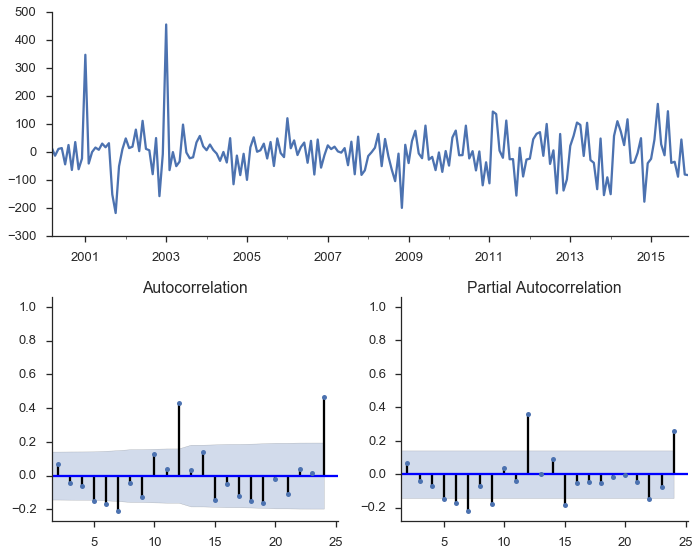

In [97]:
mod = smt.SARIMAX(y, trend='c', order=(1, 1, 1))
res = mod.fit()
tsplot(res.resid[2:], lags=24)
plt.savefig('../content/images/ts-arima.svg')

In [37]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                fl_date   No. Observations:                  192
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1104.663
Date:                Sat, 14 May 2016   AIC                           2217.326
Time:                        10:09:55   BIC                           2230.356
Sample:                    01-01-2000   HQIC                          2222.603
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7993      4.959      0.161      0.872      -8.921      10.519
ar.L1          0.3515      0.564      0.623      0.533      -0.754       1.457
ma.L1         -0.2310      0.577     -0.400      0.689      -1.361       0.899
sigma2      6181.2832    350.439     17.639      0.000    5494.435    6868.131
===================================================================================
Ljung-Box (Q):                      209.30   Jarque-Bera (JB):               424.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             1.15
Prob(H) (two-sided):                  0.54   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Things are looking better, but we still haven't accounted for seasonality.

A seasonal ARIMA model is written as $\mathrm{ARIMA}(p,d,q)×(P,D,Q)_s$.
Lowercase letters are for the non-seasonal component, just like before. Upper-case letters are a similar specification for the seasonal component, where $s$ is the periodicity (4 for quarterly, 12 for monthly).

It's like we have two processes, one for non-seasonal component and one for seasonal components, and we mulitply them together.

The general form of that looks like (quoting the statsmodels docs here)

$$\phi_p(L)\tilde{\phi}_P(L^S)\Delta^d\Delta_s^D y_t = A(t) + \theta_q(L)\tilde{\theta}_Q(L^s)e_t$$

where

- $\phi_p(L)$ is the non-seasonal autoregressive lag polynomial
- $\tilde{\phi}_P(L^S)$ is the seasonal autoregressive lag polynomial
- $\Delta^d\Delta_s^D$ is the time series, differenced  $d$ times, and seasonally differenced $D$ times.
- $A(t)$ is the trend polynomial (including the intercept)
- $\theta_q(L)$ is the non-seasonal moving average lag polynomial
- $\tilde{\theta}_Q(L^s)$  is the seasonal moving average lag polynomial

I don't find that to be very clear, but maybe an example will help. We'll fit a seasonal ARIMA$(2,0,1)×(1, 1, 1)_{12}$.

So the nonseasonal component is

- $p=2$: period autoregressive: use $y_{t-1}$ and $y_{t-2}$
- $d=0$: no first-differencing of the data
- $q=1$: use the previous non-seasonal residual, $e_{t-1}$, to forecast

And the seasonal component is

- $P=1$: use the previous seasonal value: $y_{t-12}$
- $D=1$: Difference the series 12 periods back: `y.diff(12)`
- $Q=1$: Use the previous seasonal residual, $e{t-12}$

In [38]:
mod_seasonal = smt.SARIMAX(y, trend='c',
                           order=(1, 1, 2), seasonal_order=(0, 1, 2, 12),
                           simple_differencing=False)
res_seasonal = mod_seasonal.fit()

In [39]:
res_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            fl_date   No. Observations:                  192
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -992.148
Date:                            Sat, 14 May 2016   AIC                           1998.297
Time:                                    10:09:58   BIC                           2021.099
Sample:                                01-01-2000   HQIC                          2007.532
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7824      5.279      0.148      0.882      -9.564      11.129
ar.L1         -0.9880      0.374     -2.639      0.008      -1.722      -0.254
ma.L1          0.9905      0.437      2.265      0.024       0.133       1.847
ma.L2          0.0041      0.091      0.045      0.964      -0.174       0.182
ma.S.L12      -0.7869      0.066    -11.972      0.000      -0.916      -0.658
ma.S.L24       0.2121      0.063      3.366      0.001       0.089       0.336
sigma2      3645.3299    219.296     16.623      0.000    3215.518    4075.142
===================================================================================
Ljung-Box (Q):                       47.28   Jarque-Bera (JB):               464.42
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

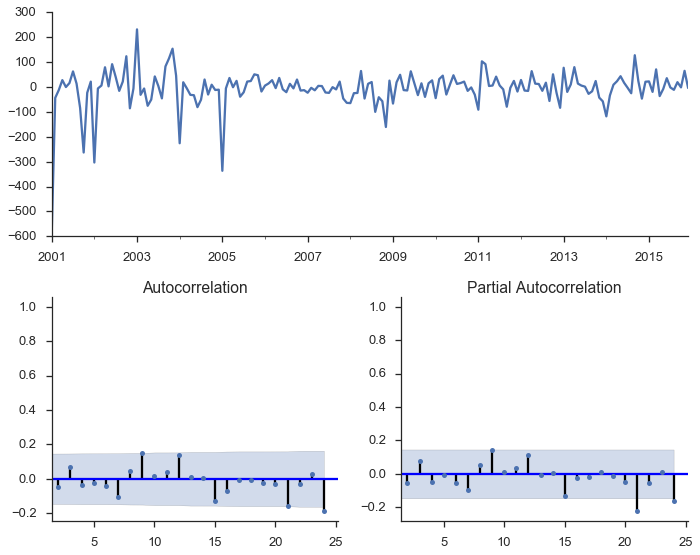

In [98]:
tsplot(res_seasonal.resid[12:], lags=24)
plt.savefig('../content/images/ts-seasonal.svg')

Things look much better now.

One thing I didn't really talk about is order selection. How to choose $p, d, q, P, D$ and $Q$.
R's forecast package does have a handy `auto.arima` function that does this for you.

## Forecasting

We can use the results to make one-step-ahead forecasts.
At each point, we take the history up to that point and make a forecast for the next month.

In [41]:
pred = res_seasonal.get_prediction(start='2001-03-01')
pred_ci = pred.conf_int()

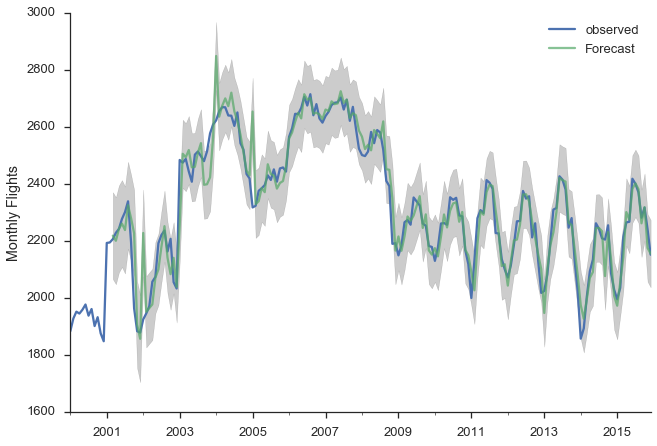

In [99]:
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_ylabel("Monthly Flights")
plt.legend()
sns.despine()
plt.savefig('../content/images/ts-one-step.svg')

Alternativly, we can make *dynamic* forcasts as of some month (January 2013 in the example below).
That means the forecast from that point foreward only use inforamtion available as of January 2013.
In this case, the predictions are generated in a simlar way: a bunch of one-step forecasts.
Only instead of plugging in the *actual* past values, we plug in the *forecast* past values.

In [43]:
pred_dy = res_seasonal.get_prediction(start='2002-03-01', dynamic='2013-01-01')
pred_dy_ci = pred_dy.conf_int()

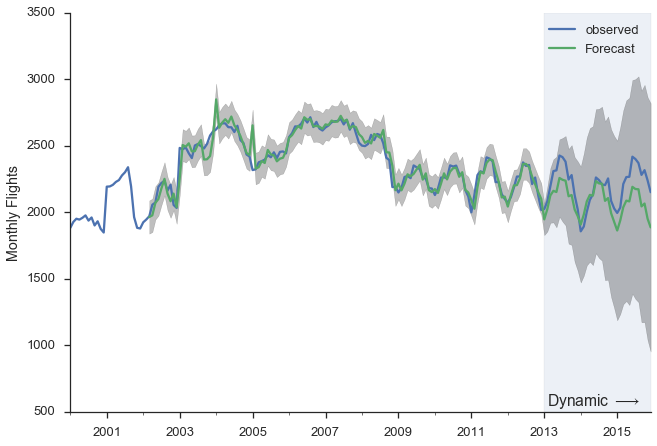

In [100]:
ax = y.plot(label='observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel("Monthly Flights")
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp('2013-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp('2013-02-01'), 550))

plt.legend()
sns.despine()
plt.savefig('../content/images/ts-dynamic.svg')

# Conclusion